In [2]:
import sys
sys.path.append('/../QmeQ/qmeq/')
#sys.path.append('../qmeq/')
import qmeq
import numpy as np
import matplotlib.pyplot as plt

In [50]:
#--SETUP for QMEQ: ---------------------------------------------------------------------------------
epsilon = 20
V_B = 20
mu_L = -V_B/2       
mu_R = V_B/2        

gammaL = 0.3
gammaR = gammaL
T_L = 2000
T_R = 0.5

In [56]:
#--------------------QmeQ parameters----------------------------------

n = 1 #single resonant energy level
h = {(0,0):epsilon}

nleads = 2
mulst = {0:mu_L, 1:mu_R}
tlst = {0:T_L, 1:T_R}

tL = np.sqrt(gammaL/np.pi/2)
tR = np.sqrt(gammaR/np.pi/2)

tleads = {(0, 0):tL, (1, 0):tR}

In [59]:
system = qmeq.Builder(nsingle=n, hsingle=h, nleads=nleads,
                         mulst=mulst, tlst=tlst, tleads=tleads, countingleads=[0], kerntype='pyPauli')

In [60]:
system.solve()
print('Standard current:',system.current)
print('Counting currents and noise at the left lead (Pauli):', system.current_noise)
print(system.success)

  Error from the solver: Singular matrix
  The reasons for such a failure can be various:
  1. Some of the transport channels may be outside the bandwidth D of the leads.
     In this case removing some of the states with the method [remove_states()] will help.
  2. Replacement of one of the equations with the normalisation condition.
     In this case try to use different [norm_row]
     or solve the linear system using [symq=False] and the solution method [solmethod='lsqr'].
  This warning will not be shown again.
  To check if the solution succeeded check the property [success].
Standard current: [0. 0.]
Counting currents and noise at the left lead (Pauli): [0. 0.]
False


In [39]:
#Main functions

def fermi(mu, E, T):
    return 1/(1+np.exp((E-mu)/T))

def calculate_current(epsilon, mu_L, mu_R, gammaL, gammaR, T_L, T_R):

    fL = fermi(mu_L, epsilon, T_L)
    fR = fermi(mu_R, epsilon, T_R)

    W_1_0 = gammaL*fL+gammaR*fR
    W_0_1 = gammaL*(1-fL)+ gammaR*(1-fR)
    Wsum = W_0_1 + W_1_0
    P_0 = W_0_1/Wsum
    P_1 = W_1_0/Wsum

    I = -(gammaR*fR*P_0 - gammaR*(1-fR)*P_1)

    #------------------calculate cumulants---------------------

    I_mean = gammaL*gammaR*(fL-fR)/(gammaL+gammaR)
    I_var =  gammaL*gammaR*((gammaL**2+gammaR**2)*(fL+fR-2*fL*fR)+2*gammaL*gammaR*(fL*(1-fL)+fR*(1-fR)))/((gammaL+gammaR)**3)
    #(Not actually exactly variance apparently...)

    return I, I_mean, I_var

def calculate_heat_current(I, epsilon, mu):
    E = epsilon*I
    Q = E-mu*I
    return Q



9.959959959959967


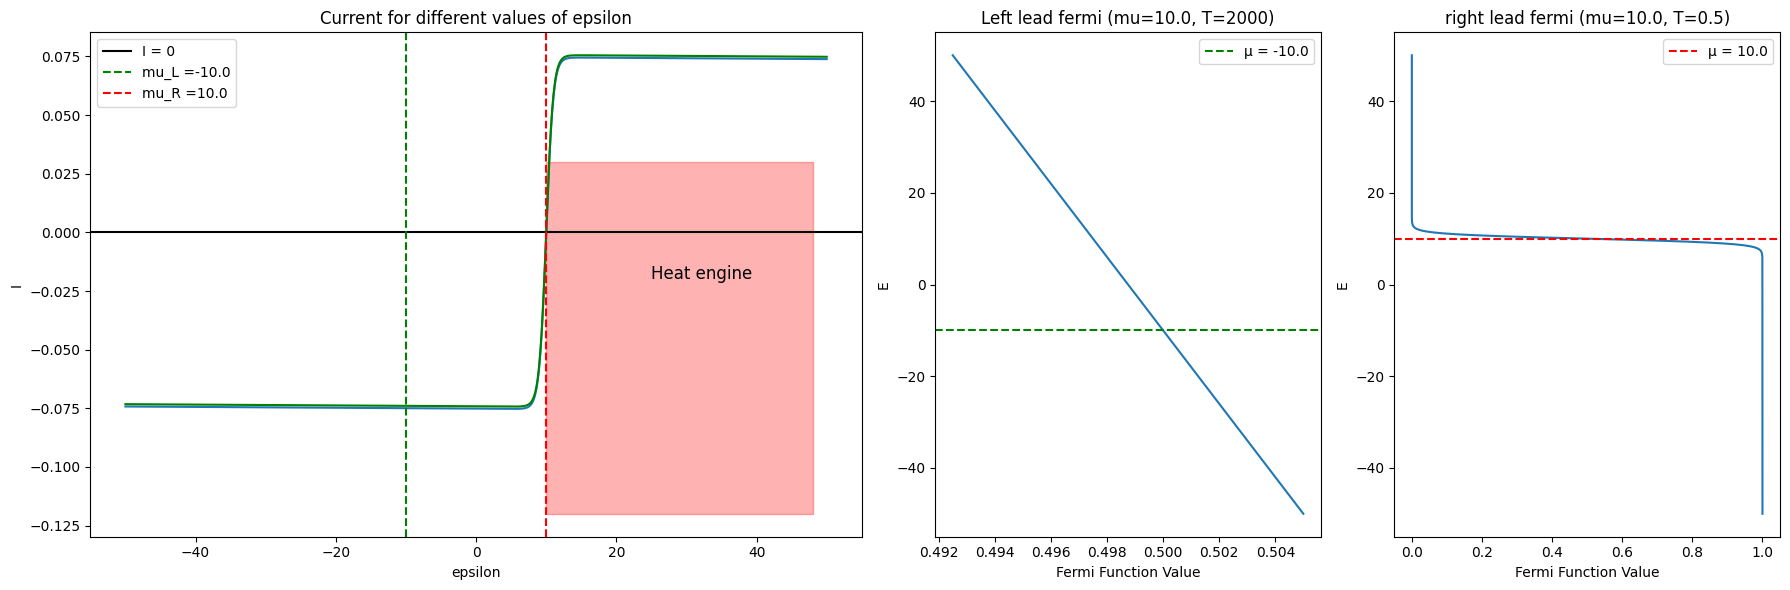

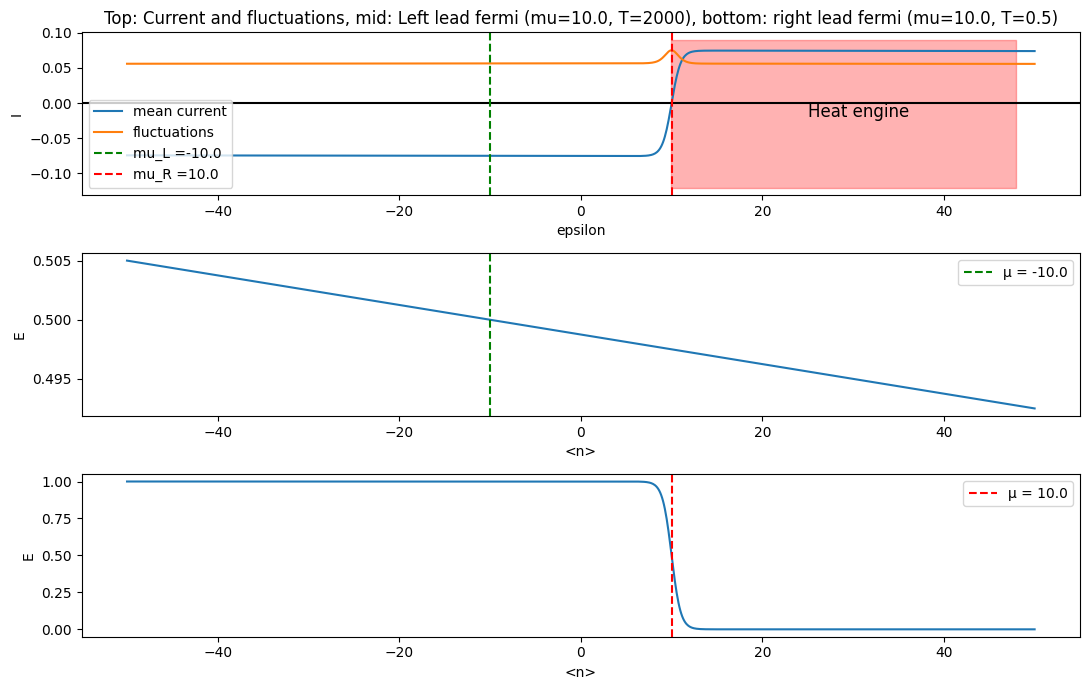

In [47]:
# HEAT ENGINE VB = 30



#--SETUP: ---------------------------------------------------------------------------------
epsilon = np.linspace(-50,50,1000)
V_B = 20
mu_L = -V_B/2       
mu_R = V_B/2        


gammaL = 0.3
gammaR = gammaL
T_L = 2000
T_R = 0.5
#---------------------------------------------------------------------------------------------

INPUT = {'epsilon': epsilon,         
            'mu_L': mu_L,
            'mu_R': mu_R,
            'gammaL': gammaL,                   # gamma in left lead
            'gammaR': gammaR,                 # gamma in right lead
            'T_L': T_L,          # Temperature in left lead
            'T_R': T_R}                    # Temperature in right lead
#------------------------------------------------------------------------------------------

I, I_mean, I_var = calculate_current(**INPUT)
idx = np.argmin(np.abs(I))
eps_at_zero_I = epsilon[idx]
print(eps_at_zero_I)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1, 1]}) 

y_lower, y_upper = -0.12, 0.03
x_lower, x_upper = -48, 48
ax1.plot(epsilon, I)
ax1.plot(epsilon, I_mean+0.001, color='green')
#ax1.set_ylim(y_lower, y_upper)
#ax1.set_xlim(x_lower, x_upper)
ax1.fill_between(epsilon, y_lower, y_upper, where=(epsilon >= eps_at_zero_I) & (epsilon <= x_upper), color='red', alpha=0.3)
ax1.annotate('Heat engine', 
             xy=(25, -0.02),  # Position of the annotation
             xytext=(25, -0.02),  # Position of the text
             fontsize=12, color='black')  # Text customization
ax1.axhline(y=0, color='black', linestyle='-', label='I = 0')
ax1.axvline(x=mu_L, color='g', linestyle='--', label=f'mu_L ={mu_L}')
ax1.axvline(x=mu_R, color='r', linestyle='--', label=f'mu_R ={mu_R}')
ax1.set_xlabel('epsilon')
ax1.set_ylabel('I')
ax1.set_title('Current for different values of epsilon')
ax1.legend()

# Second plot - Fermi function in Left lead
fermi_L = fermi(mu_L, epsilon, T_L)
ax2.plot(fermi_L, epsilon)
ax2.axhline(y=mu_L, color='g', linestyle='--', label=f'μ = {mu_L}') 
ax2.set_xlabel('Fermi Function Value')
ax2.set_ylabel('E')
ax2.set_title(f'Left lead fermi (mu={mu_R}, T={T_L})')
ax2.legend()

# Third plot - Fermi function in right lead
fermi_R = fermi(mu_R, epsilon, T_R)
ax3.plot(fermi_R, epsilon)
ax3.axhline(y=mu_R, color='r', linestyle='--', label=f'μ = {mu_R}')
ax3.set_xlabel('Fermi Function Value')
ax3.set_ylabel('E')
ax3.set_title(f'right lead fermi (mu={mu_R}, T={T_R})')
ax3.legend()

plt.tight_layout()  # Adjust layout to prevent overlap

#------------------------------------------------------------------------------------------------
#/////////////////////////////////--PLOTTING THE CUMMULANTS--\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 7)) 

y_upper = 0.09
ax1.plot(epsilon, I, label='mean current')
ax1.plot(epsilon, I_var, label='fluctuations')
#ax1.set_ylim(y_lower, y_upper)
#ax1.set_xlim(x_lower, x_upper)
ax1.fill_between(epsilon, y_lower, y_upper, where=(epsilon >= eps_at_zero_I) & (epsilon <= x_upper), color='red', alpha=0.3)
ax1.annotate('Heat engine', 
             xy=(25, -0.02),  # Position of the annotation
             xytext=(25, -0.02),  # Position of the text
             fontsize=12, color='black')  # Text customization
ax1.axhline(y=0, color='black', linestyle='-')
ax1.axvline(x=mu_L, color='g', linestyle='--', label=f'mu_L ={mu_L}')
ax1.axvline(x=mu_R, color='r', linestyle='--', label=f'mu_R ={mu_R}')
ax1.set_xlabel('epsilon')
ax1.set_ylabel('I')
ax1.set_title(f'Top: Current and fluctuations, mid: Left lead fermi (mu={mu_R}, T={T_L}), bottom: right lead fermi (mu={mu_R}, T={T_R})')
ax1.legend(loc="lower left")

# Second plot - Fermi function in Left lead
fermi_L = fermi(mu_L, epsilon, T_L)
ax2.plot(epsilon, fermi_L)
ax2.axvline(x=mu_L, color='g', linestyle='--', label=f'μ = {mu_L}') 
ax2.set_xlabel('<n>')
ax2.set_ylabel('E')
ax2.legend()

# Third plot - Fermi function in right lead
fermi_R = fermi(mu_R, epsilon, T_R)
ax3.plot(epsilon, fermi_R)
ax3.axvline(x=mu_R, color='r', linestyle='--', label=f'μ = {mu_R}')
ax3.set_xlabel('<n>')
ax3.set_ylabel('E')
ax3.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

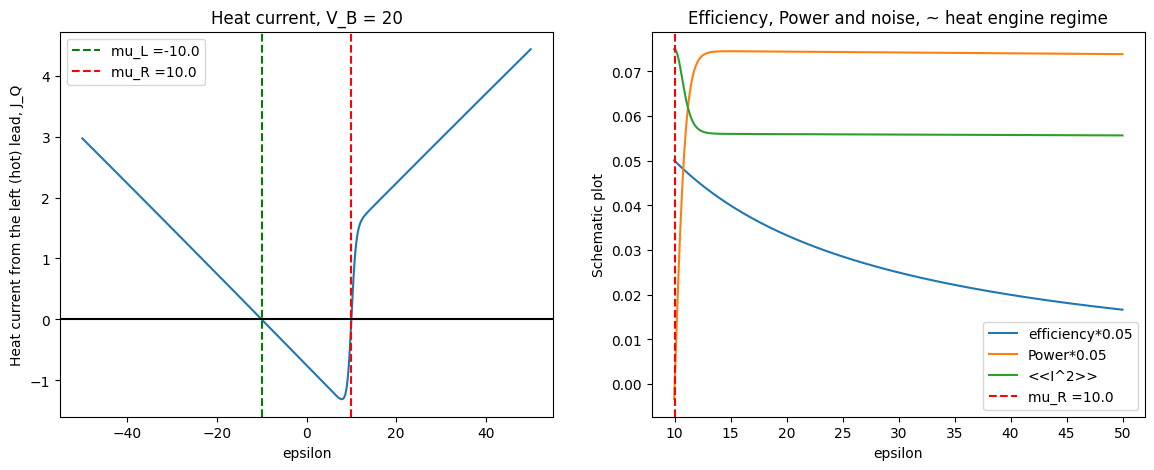

In [48]:
#Heat current and efficiency

J_QH = calculate_heat_current(I, epsilon, mu_L)
P = I*V_B
efficiency = P/J_QH

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 
ax1.plot(epsilon, J_QH)
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Heat current from the left (hot) lead, J_Q')
ax1.set_title(f'Heat current, V_B = {V_B}')
ax1.axhline(y=0, color='black', linestyle='-')
ax1.axvline(x=mu_L, color='g', linestyle='--', label=f'mu_L ={mu_L}')
ax1.axvline(x=mu_R, color='r', linestyle='--', label=f'mu_R ={mu_R}')
ax1.legend()

idx = np.argmin(np.abs(epsilon - mu_R))
ax2.plot(epsilon[idx:], 0.05*efficiency[idx:], label='efficiency*0.05')
ax2.plot(epsilon[idx:], 0.05*P[idx:], label='Power*0.05')
ax2.plot(epsilon[idx:], I_var[idx:], label='<<I^2>>')
ax2.set_xlabel('epsilon')
ax2.set_ylabel('Schematic plot')
ax2.set_title('Efficiency, Power and noise, ~ heat engine regime')
ax2.axvline(x=mu_R, color='r', linestyle='--', label=f'mu_R ={mu_R}')
ax2.legend()

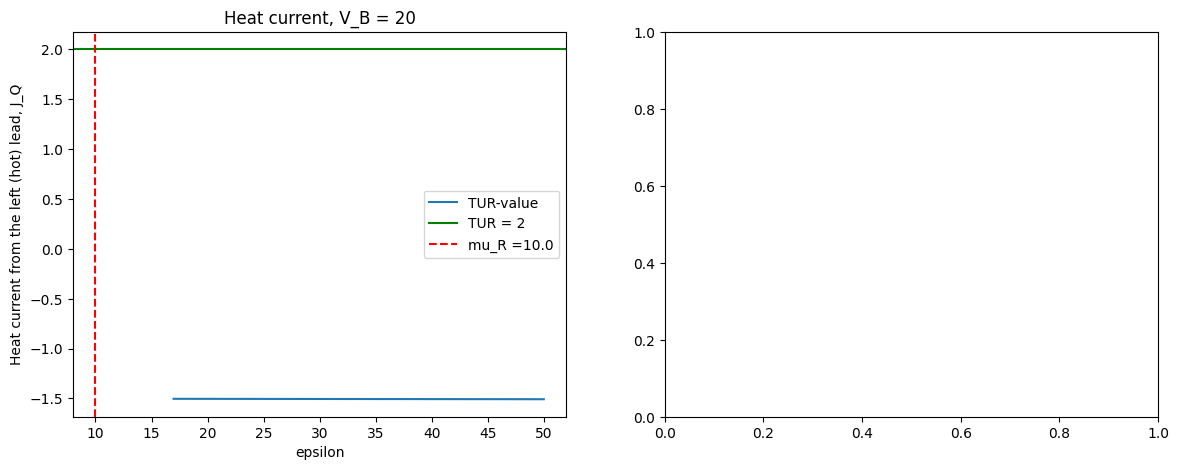

In [49]:
#TUR

#Left lead = hot
#Right lead = cold

eff_carnot = 1-T_R/T_L
ent_prod = I*(1/T_R)*(-efficiency)/efficiency
TUR = I_var*ent_prod/(I**2)

#Value 17 hand tuned
idx = np.argmin(np.abs(epsilon - 17))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 
ax1.plot(epsilon[idx:], TUR[idx:], label='TUR-value')
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Heat current from the left (hot) lead, J_Q')
ax1.set_title(f'Heat current, V_B = {V_B}')
ax1.axhline(y=2, color='g', linestyle='-', label= 'TUR = 2')
ax1.axvline(x=mu_R, color='r', linestyle='--', label=f'mu_R ={mu_R}')
ax1.legend()